In [1]:
from CherryTreeDataset import CherryTreeDataset
from torchvision import transforms
from auxii import plot_spectra
from resnet_adapters import adapt_resnet_channels
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision.models as models
from torchvision.models import ResNet18_Weights, ResNet50_Weights
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn


In [2]:
# Define las transformaciones si son necesarias
transform = transforms.Compose([
    transforms.Resize((256,256)),
    #transforms.Resize((1280, 960)),
    transforms.ToTensor(),
])

#formats = ('RGB.JPG', 'RED.TIF','GRE.TIF','NIR.TIF','REG.TIF')
#formats = ('RGB.JPG','NIR.TIF','REG.TIF')
formats = ('RGB.JPG',)


In [3]:


full_dataset = CherryTreeDataset('/mnt/d/Maestria/tfm/7144071', transform=transform, formats=formats, concatenate=True, balance=False)

healthy_indices_full = [i for i, (_, label) in enumerate(full_dataset.samples) if label == 0]

# División en conjuntos de entrenamiento y prueba
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# Ajustar los índices saludables al train_dataset
healthy_indices_train = [i for i in range(len(train_dataset)) if i in train_dataset.indices and train_dataset.indices[i] in healthy_indices_full]

# Configurar los DataLoader usando los índices filtrados
train_loader = DataLoader(train_dataset, batch_size=10, sampler=SubsetRandomSampler(healthy_indices_train), num_workers=20)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True, num_workers=20)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'El dispositivo seleccionado es {device}')

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder: Reducción progresiva de la dimensionalidad a través de más capas convolucionales
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),  # Reducción espacial (H/2, W/2)
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # Reducción espacial (H/4, W/4)
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # Reducción espacial (H/8, W/8)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.Conv2d(128, 256, 3, stride=2, padding=1),  # Reducción espacial (H/16, W/16)
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.Conv2d(256, 512, 3, stride=2, padding=1),  # Reducción espacial (H/32, W/32)
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )
        
        # Decoder: Recuperación progresiva de la dimensionalidad original
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1),  # Expansión (H/16, W/16)
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),  # Expansión (H/8, W/8)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  # Expansión (H/4, W/4)
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # Expansión (H/2, W/2)
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),  # Expansión a tamaño original (H, W)
            nn.Tanh()  # Para asegurar que la salida esté en el rango [-1, 1]
        )

        # Inicialización de pesos
        self._initialize_weights()

    def forward(self, x):
        # Propagación hacia adelante del encoder y decoder
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def _initialize_weights(self):
        # Inicialización de los pesos de manera más robusta
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


El dispositivo seleccionado es cuda


In [5]:
model = ConvAutoencoder()
model.to(device)  # Mueve el modelo al dispositivo apropiado (CPU o GPU)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)  # Define el optimizador
criterion = nn.MSELoss()  # Define la función de pérdida

# DataLoader para los datos de entrenamiento
# Asegúrate de que el DataLoader solo devuelva datos normales para el entrenamiento

def train_model(model, dataloader, criterion, optimizer, num_epochs=2):
    model.train()  # Poner el modelo en modo de entrenamiento
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, _ in dataloader:  # Ignora las etiquetas porque no son necesarias para el entrenamiento
            inputs = inputs.to(device)  # Mueve los datos al dispositivo

            optimizer.zero_grad()  # Limpia los gradientes de los parámetros del optimizador

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, inputs)  # Calcula la pérdida de reconstrucción

            # Backward pass y optimización
            loss.backward()  # Calcula los gradientes
            optimizer.step()  # Actualiza los pesos

            running_loss += loss.item() * inputs.size(0)  # Acumula la pérdida del lote

        epoch_loss = running_loss / len(dataloader.dataset)  # Calcula la pérdida promedio por época
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# Llamar a la función de entrenamiento
train_model(model, train_loader, criterion, optimizer, num_epochs=50)

Epoch 1/50, Loss: 0.5464
Epoch 2/50, Loss: 0.3957
Epoch 3/50, Loss: 0.3667
Epoch 4/50, Loss: 0.3525
Epoch 5/50, Loss: 0.3436
Epoch 6/50, Loss: 0.3364
Epoch 7/50, Loss: 0.3288
Epoch 8/50, Loss: 0.3237
Epoch 9/50, Loss: 0.3190
Epoch 10/50, Loss: 0.3140
Epoch 11/50, Loss: 0.3098
Epoch 12/50, Loss: 0.3059
Epoch 13/50, Loss: 0.3023
Epoch 14/50, Loss: 0.2997
Epoch 15/50, Loss: 0.2972
Epoch 16/50, Loss: 0.2946
Epoch 17/50, Loss: 0.2928
Epoch 18/50, Loss: 0.2909
Epoch 19/50, Loss: 0.2890
Epoch 20/50, Loss: 0.2884
Epoch 21/50, Loss: 0.2864
Epoch 22/50, Loss: 0.2853
Epoch 23/50, Loss: 0.2845
Epoch 24/50, Loss: 0.2830
Epoch 25/50, Loss: 0.2819
Epoch 26/50, Loss: 0.2806
Epoch 27/50, Loss: 0.2800
Epoch 28/50, Loss: 0.2788
Epoch 29/50, Loss: 0.2787
Epoch 30/50, Loss: 0.2776
Epoch 31/50, Loss: 0.2766
Epoch 32/50, Loss: 0.2757
Epoch 33/50, Loss: 0.2751
Epoch 34/50, Loss: 0.2743


KeyboardInterrupt: 

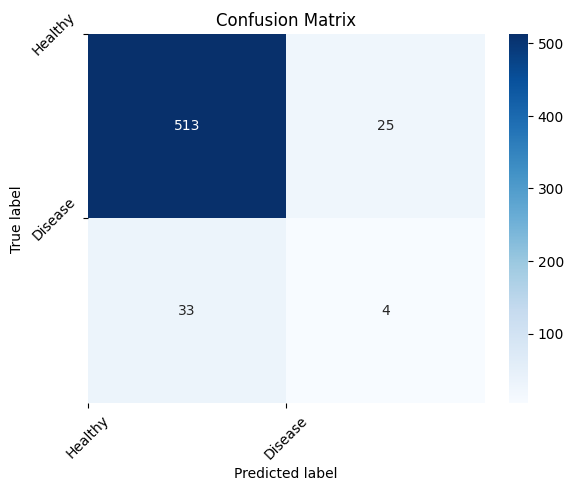

In [6]:
import torch
from torch.utils.data import DataLoader
import numpy as np

def calculate_reconstruction_error(model, dataloader, device):
    model.eval()
    reconstruction_errors = []
    true_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            reconstructions = model(data)
            mse = torch.nn.functional.mse_loss(reconstructions, data, reduction='none')
            mse = mse.mean([1, 2, 3])  # Promedio por imagen
            reconstruction_errors.extend(mse.cpu().numpy())
            true_labels.extend(labels.numpy())  # Asumiendo que las etiquetas están en un tensor
    return np.array(reconstruction_errors), np.array(true_labels)

def determine_threshold(errors, percentile=95):
    return np.percentile(errors, percentile)

def detect_anomalies(errors, threshold):
    return errors > threshold

# Calcula errores de reconstrucción
errors, true_labels = calculate_reconstruction_error(model, test_loader, device)
threshold = determine_threshold(errors)
predicted_labels = detect_anomalies(errors, threshold).astype(int)
cm = confusion_matrix(true_labels, predicted_labels)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes, rotation=45)
    plt.show()

# Supongamos que las clases son [0, 1] donde '0' es 'Healthy' y '1' es 'Disease'
plot_confusion_matrix(cm, classes=['Healthy', 'Disease'])

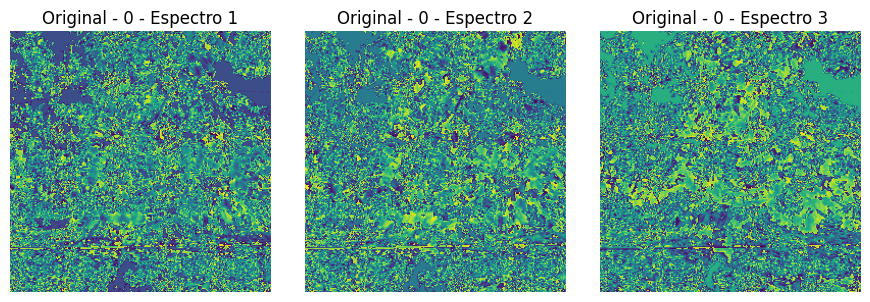

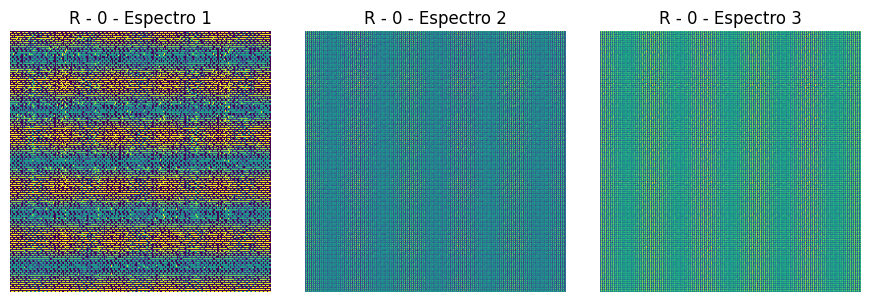

In [7]:
images, label = full_dataset[25]

# Convertir la imagen al dispositivo adecuado y añadir una dimensión de lote si es necesario
image = images.to(device).unsqueeze(0)

# Instancia del modelo
model = ConvAutoencoder().to(device)

# Asegurarse de que el modelo está en modo evaluación
model.eval()

# Obtener la reconstrucción
with torch.no_grad():
    reconstruction = model(image)

# Quitar la dimensión del lote para visualización y mover a CPU
input_image = image.squeeze(0).cpu()
reconstructed_image = reconstruction.squeeze(0).cpu()

# Usar la función plot_spectra para visualizar las imágenes
plot_spectra(input_image, f'Original - {label}')
plot_spectra(reconstructed_image, f'R - {label}')